In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"niggasus","key":"33c8da30165c2640c0f30c9df8c65f30"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 64% 95.0M/149M [00:00<00:00, 994MB/s]
100% 149M/149M [00:00<00:00, 822MB/s] 


In [4]:
import zipfile
import os

# unzip the dataset
zip_path = "/content/brain-tumor-mri-dataset.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/Brain_tumor")

# check extracted folders
os.listdir("/content/Brain_tumor")

['Testing', 'Training']

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')


In [6]:
path = "/content/Brain_tumor"

In [7]:
df_train = os.path.join(path ,'Training')
df_test = os.path.join(path, 'Testing')

In [8]:
img_size = 224
bat_size = 32

In [9]:
train_generator = tf.keras.utils.image_dataset_from_directory(
    df_train,
    labels="inferred",
    image_size=(img_size, img_size),
    batch_size=bat_size,
    color_mode="grayscale",
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=42
)

classes = train_generator.class_names
print(f"{classes}")

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
['glioma', 'meningioma', 'notumor', 'pituitary']


In [10]:
validation_generator = tf.keras.utils.image_dataset_from_directory(
    df_train,
    labels="inferred",
    image_size=(img_size, img_size),
    batch_size=bat_size,
    color_mode="grayscale",
    validation_split=0.2,
    subset="validation",
    seed=42
)

test_generator = tf.keras.utils.image_dataset_from_directory(
        df_test ,
        labels = "inferred",
        image_size=(img_size, img_size),
        batch_size=bat_size,
        color_mode='grayscale'
)



Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.


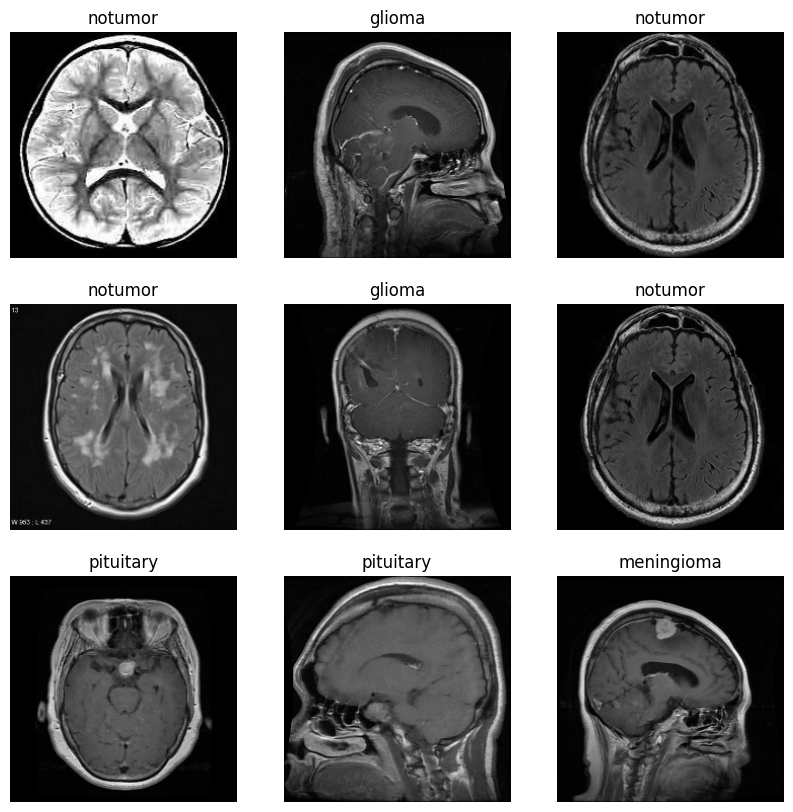

In [11]:
plt.figure(figsize=(10, 10))
for images , labels in train_generator.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8') , cmap = 'gray')
        plt.title(classes[labels[i]])
        plt.axis('off')
    plt.show()

In [12]:
train_generator = train_generator.map(lambda x,y : (x/255,y))
validation_generator = validation_generator.map(lambda x,y : (x/255,y))
test_generator = test_generator.map(lambda x,y : (x/255,y))

In [13]:
model = Sequential([
    Conv2D(32 , (3,3) , activation = 'relu' , input_shape = (img_size, img_size, 1)),
    MaxPooling2D((2,2)),
    Conv2D(64 , (3,3) , activation = 'relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Conv2D(128 , (3,3) , activation = 'relu'),
    MaxPooling2D((2,2)),
    Conv2D(256 , (3,3) , activation = 'relu'),
    MaxPooling2D((2,2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(classes), activation='softmax')

])


model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,107,076 (19.48 MB)

 Trainable params: 5,107,076 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])

In [15]:
epochs = 15

model.fit(
    train_generator,
    epochs = epochs,
    validation_data = validation_generator
    )

Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 655s 5s/step - accuracy: 0.5628 - loss: 0.9877 - val_accuracy: 0.7811 - val_loss: 0.5523
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 609s 4s/step - accuracy: 0.8308 - loss: 0.4354 - val_accuracy: 0.8827 - val_loss: 0.3491
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 648s 5s/step - accuracy: 0.8839 - loss: 0.3112 - val_accuracy: 0.8967 - val_loss: 0.2855
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 610s 4s/step - accuracy: 0.9109 - loss: 0.2355 - val_accuracy: 0.8634 - val_loss: 0.4267
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 619s 4s/step - accuracy: 0.9238 - loss: 0.2045 - val_accuracy: 0.9186 - val_loss: 0.2686
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 603s 4s/step - accuracy: 0.9556 - loss: 0.1167 - val_accuracy: 0.9326 - val_loss: 0.2198
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 603s 4s/step - accuracy: 0.9665 - loss: 0.0894 - val_accuracy: 0.9387 - val_loss: 0.2557
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 643s 5s/step - accuracy: 0.9710 - loss: 0.0784 - val_accu

In [16]:
loss , accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.9617 - loss: 0.2240
Test Loss: 0.2191426306962967, Test Accuracy: 0.9580472707748413


In [17]:
y_true = []
images = []
for image, label in test_generator:
    y_true.extend(label.numpy())
    images.extend(image.numpy())

In [18]:
y_pred = model.predict(np.array(images))

41/41 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step


In [27]:
y_pred = model.predict(np.array(images))
y_pred_classes = np.argmax(y_pred, axis=1)   # probability → class index

import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Agar y_true one-hot encoded hai to use integer class bana do
if len(np.array(y_true).shape) > 1 and np.array(y_true).shape[1] > 1:
    y_true_classes = np.argmax(y_true, axis=1)
else:
    y_true_classes = np.array(y_true)

# Accuracy
acc = accuracy_score(y_true_classes, y_pred_classes)
print("Accuracy:", acc)

# Precision, Recall, F1-score
print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=classes))


41/41 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step
Accuracy: 0.958047292143402

Classification Report:

              precision    recall  f1-score   support

      glioma       0.94      0.94      0.94       300
  meningioma       0.92      0.92      0.92       306
     notumor       0.98      0.99      0.98       405
   pituitary       0.98      0.97      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



In [38]:
# Convert predictions (probabilities) to class indices
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure y_true is integer
y_true_classes = np.array(y_true).astype(int)

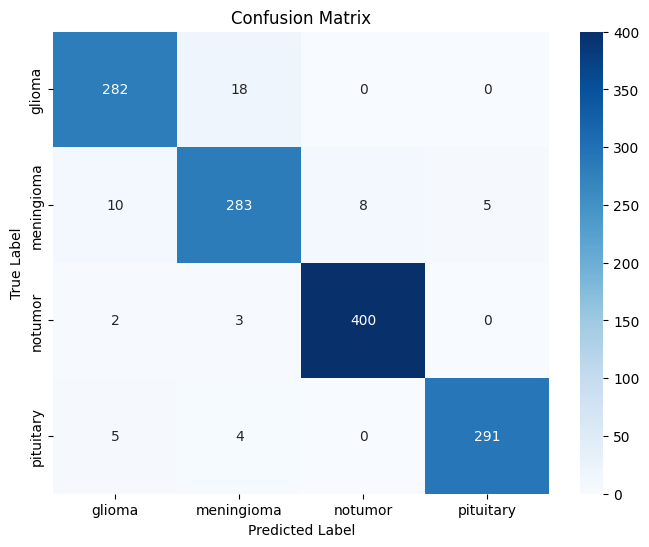

In [40]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [41]:
print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=classes))


Classification Report:

              precision    recall  f1-score   support

      glioma       0.94      0.94      0.94       300
  meningioma       0.92      0.92      0.92       306
     notumor       0.98      0.99      0.98       405
   pituitary       0.98      0.97      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.96      0.96      1311
weighted avg       0.96      0.96      0.96      1311



In [42]:
model.save('model.h5')

In [43]:
img_path = "/content/Brain_tumor/Testing/notumor/Te-no_0130.jpg"



In [44]:
def prediction(img_path):
    img = tf.keras.utils.load_img(img_path, color_mode='grayscale', target_size=(img_size, img_size))
    img = tf.keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0) / 255.0
    predictions = model.predict(img)
    predicted_class = np.argmax(predictions[0])
    print(f"Predicted probabilities: {np.max(predictions[0])*100:.2f}% for {classes[predicted_class]}")

    sns.barplot(x=classes, y=predictions[0], palette= 'Set3')

    plt.xlabel('Classes')
    plt.ylabel('Probability')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Predicted probabilities: 100.00% for notumor


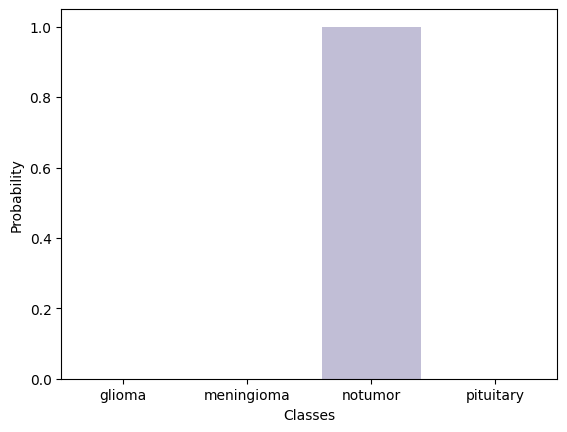

In [45]:
prediction(img_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Predicted probabilities: 100.00% for glioma


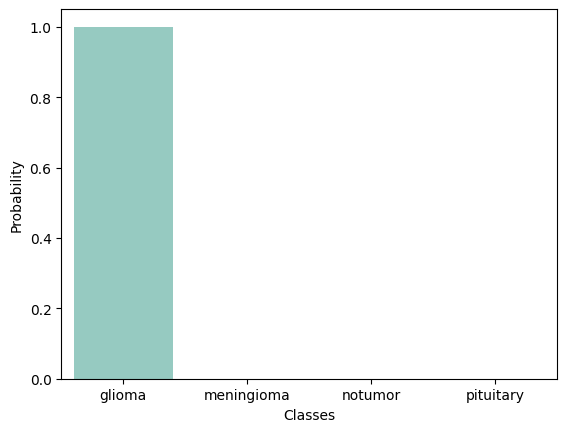

In [52]:
image2 = "/content/Brain_tumor/Testing/glioma/Te-gl_0026.jpg"
prediction(image2)